# Assignment 1 - Water Quality

<details>
  <summary><span style="font-size:1.5em; font-weight:bold; color:#1f77b4;">Given</span></summary>

  <p>
In this project, we provide a water quality dataset from the Central Pollution Control Board
(CPCB). You will use this dataset to predict water quality.

Access to clean water is a fundamental necessity, yet water quality can vary significantly based
on environmental, geographical, and human factors. The dataset includes water quality
monitoring data from across India, with chemical and physical parameters measured at various
locations over different years (2019, 2020, 2021, 2022).

The dataset contains the following columns:
pi
Well_ID, State, District, Block, Village: Geographical identifiers of water sampling locations.

Latitude, Longitude: Spatial coordinates for precise mapping.

Year: The year in which the sample was recorded.

Water Quality Indicators: pH, Electrical Conductivity (EC), Carbonates (CO3), Bicarbonates
(HCO3), Chlorides (CI), Sulfates (SO4), Nitrates (NO3), Total Hardness (TH), Calcium (Ca),
Magnesium (Mg), Sodium (Na), Potassium (K), Fluoride (F), Total Dissolved Solids (TDS).

Target Variables:

Water Quality Index (WQI): A numerical representation of overall water quality derived from
chemical and physical parameters.

Water Quality Classification: A categorical label indicating the quality of water (e.g., Good, Poor,
Unsuitable for Drinking).
  </p>
</details>

<details>
  <summary><span style="font-size:1.5em; font-weight:bold; color:#1f77b4;">Deliverables</span></summary>

  <p>
In this project, your task is to build Deep Learning Neural Networks to predict the following:

Water Quality Index (WQI)

Water Quality Classification

You can download the dataset from the attachment provided and build the models using that.
Once the models are built, calculate metrics such as the R2 score for regression and accuracy/F1
score for classification, and submit your ipynb file for evaluation.
  </p>
</details>

## Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score, f1_score
import numpy as np


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

## EDA

In [2]:
# Loading data
df = pd.read_csv('./data/water_quality.csv')

df.head()

,Well_ID,State,District,Block,Village,Latitude,Longitude,Year,pH,EC,...,NO3,TH,Ca,Mg,Na,K,F,TDS,WQI,Water Quality Classification
0,W232200071580001,Gujarat,Ahmedabad,Mandal,Dalod,NaN,NaN,2020,8.20,16640.0,...,26.00,1451.0,152.0,260.0,3535.0,45.0,1.00,11149,4361.44080,Unsuitable for Drinking
1,W254029084355301,Himachal Pradesh,Solan,Nallagarh,JAGATPUR,31.1594,76.678500,2019,8.44,299.0,...,2.70,84.0,17.0,10.0,39.0,2.4,0.20,262,85.80466,Good
2,W193530074180001,Maharashtra,Ahmednagar,SANGAMNER,Kokangaon,74.3000,19.591667,2022,7.90,1315.0,...,18.20,465.0,80.2,64.4,88.3,1.6,0.53,372,280.04130,Very Poor yet Drinkable
3,W231620072033001,Gujarat,Ahmedabad,Viramgam,Endla,NaN,NaN,2020,7.40,715.0,...,0.23,280.0,56.0,34.0,47.0,11.0,0.46,479,195.11649,Poor
4,W251908084361501,Himachal Pradesh,Solan,Nallagarh,BARUNA,31.1540,76.638400,2019,8.40,270.0,...,10.00,116.0,10.0,18.0,23.0,1.0,0.12,262,81.77860,Good


In [3]:
print(f"The dataset contains the following columns:\n{', '.join(df.columns.to_list())}")

The dataset contains the following columns:
Well_ID, State, District, Block, Village, Latitude, Longitude, Year, pH, EC, CO3, HCO3, Cl, SO4, NO3, TH, Ca, Mg, Na, K, F, TDS, WQI, Water Quality Classification


### 📌 Dropping Location and Metadata Columns

We drop the columns `Well_ID`, `State`, `District`, `Block`, `Village`, `Latitude`, `Longitude`, and `Year` because they do not contribute directly to assessing water quality. These fields serve as identifiers or contextual metadata, while the dataset already includes precise chemical measurements (e.g., pH, TDS, NO₃) that directly determine water quality. By removing non-essential columns, we streamline the dataset and focus the analysis on the actual water quality indicators.

### 🎯 Target Variable Selection

We use **Water Quality Index (WQI)** as the target variable for modeling and prediction, rather than the `Water Quality Classification`. The classification is a **direct categorical interpretation** of the WQI value, as shown in the reference table:

![WQI vs WQC table](https://www.researchgate.net/publication/331444758/figure/tbl3/AS:937054867292162@1600422698596/The-WQI-range-and-water-quality-classifica-tion-for-drinking-purposes.png)

Since the classification is **derived directly from WQI**, including both as targets would be redundant. By predicting WQI, we can **infer the classification** using predefined thresholds, keeping the model focused and avoiding leakage from derived labels.

### 📊 Investigating the WQI–Classification Relationship

We created a boxplot to investigate whether the `Water Quality Classification` aligns correctly with the `Water Quality Index (WQI)` values. Since the classification is derived from WQI ranges, this visualization helps validate the hypothesis that the classification labels are consistent with the underlying index. By plotting WQI against each classification category, we can visually confirm whether the WQI values fall within the expected thresholds defined in the reference table. This step ensures the integrity of the labels and supports using WQI as the sole target variable for modeling.

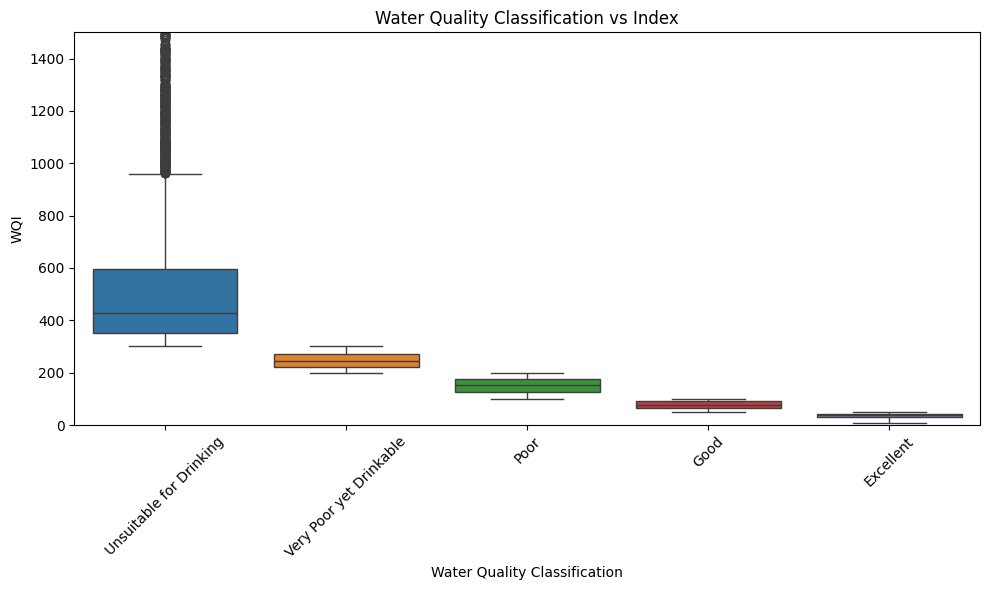

In [4]:
# Create scatter plot
plt.figure(figsize=(10, 6))

# Define desired order for classification
classification_order = ['Unsuitable for Drinking', 'Very Poor yet Drinkable', 'Poor', 'Good', 'Excellent']

df['Water Quality Classification'] = pd.Categorical(
    df['Water Quality Classification'],
    categories=classification_order,
    ordered=True
)

sns.boxplot(
    x='Water Quality Classification',
    y="WQI", 
    data=df,
    hue='Water Quality Classification'
)

# Customize plot
plt.title('Water Quality Classification vs Index')
plt.xlabel('Water Quality Classification')
plt.ylabel('WQI')
plt.ylim([0, 1500])
plt.xticks(rotation=45)
plt.tight_layout()

The plot clearly demonstrates that the **Water Quality Index (WQI)** serves as a direct and reliable indicator for water quality classification. Each classification corresponds to a specific WQI range, meaning the label assigned to a data point is determined solely by the interval in which its WQI value falls. Given this strong correlation, we include **WQI as a predictor** in our modeling pipeline, allowing us to infer the classification programmatically and ensure consistency across the dataset.

In [5]:
# Group by classification and calculate min and max WQI
wqi_stats = df.groupby('Water Quality Classification', observed=False)['WQI'].agg(['min', 'max']).reset_index()

# Display the result
print("Minimum and Maximum WQI values for each Water Quality Classification:")
wqi_stats

Minimum and Maximum WQI values for each Water Quality Classification:


,Water Quality Classification,min,max
0,Unsuitable for Drinking,300.011380,6850.88872
1,Very Poor yet Drinkable,200.011080,299.99592
2,Poor,100.019120,199.99532
3,Good,50.026635,99.92520
4,Excellent,9.043604,49.95470


### 🧠 Inferring Water Quality Classification from WQI

Based on the observed WQI ranges for each classification, we define the following logic to infer the water quality category directly from the Water Quality Index (WQI):

In [6]:
def classify_water_quality(wqi):
    if wqi >= 300:
        return "Unsuitable for Drinking"
    elif wqi >= 200:
        return "Very Poor yet Drinkable"
    elif wqi >= 100:
        return "Poor"
    elif wqi >= 50:
        return "Good"
    elif wqi >= 0:
        return "Excellent"
    else:
        return "Unknown"

This function uses the minimum WQI thresholds observed in each category to assign a classification. It ensures consistency with the dataset and allows automatic labeling based on WQI values.

### Feature Distribution & Transformation

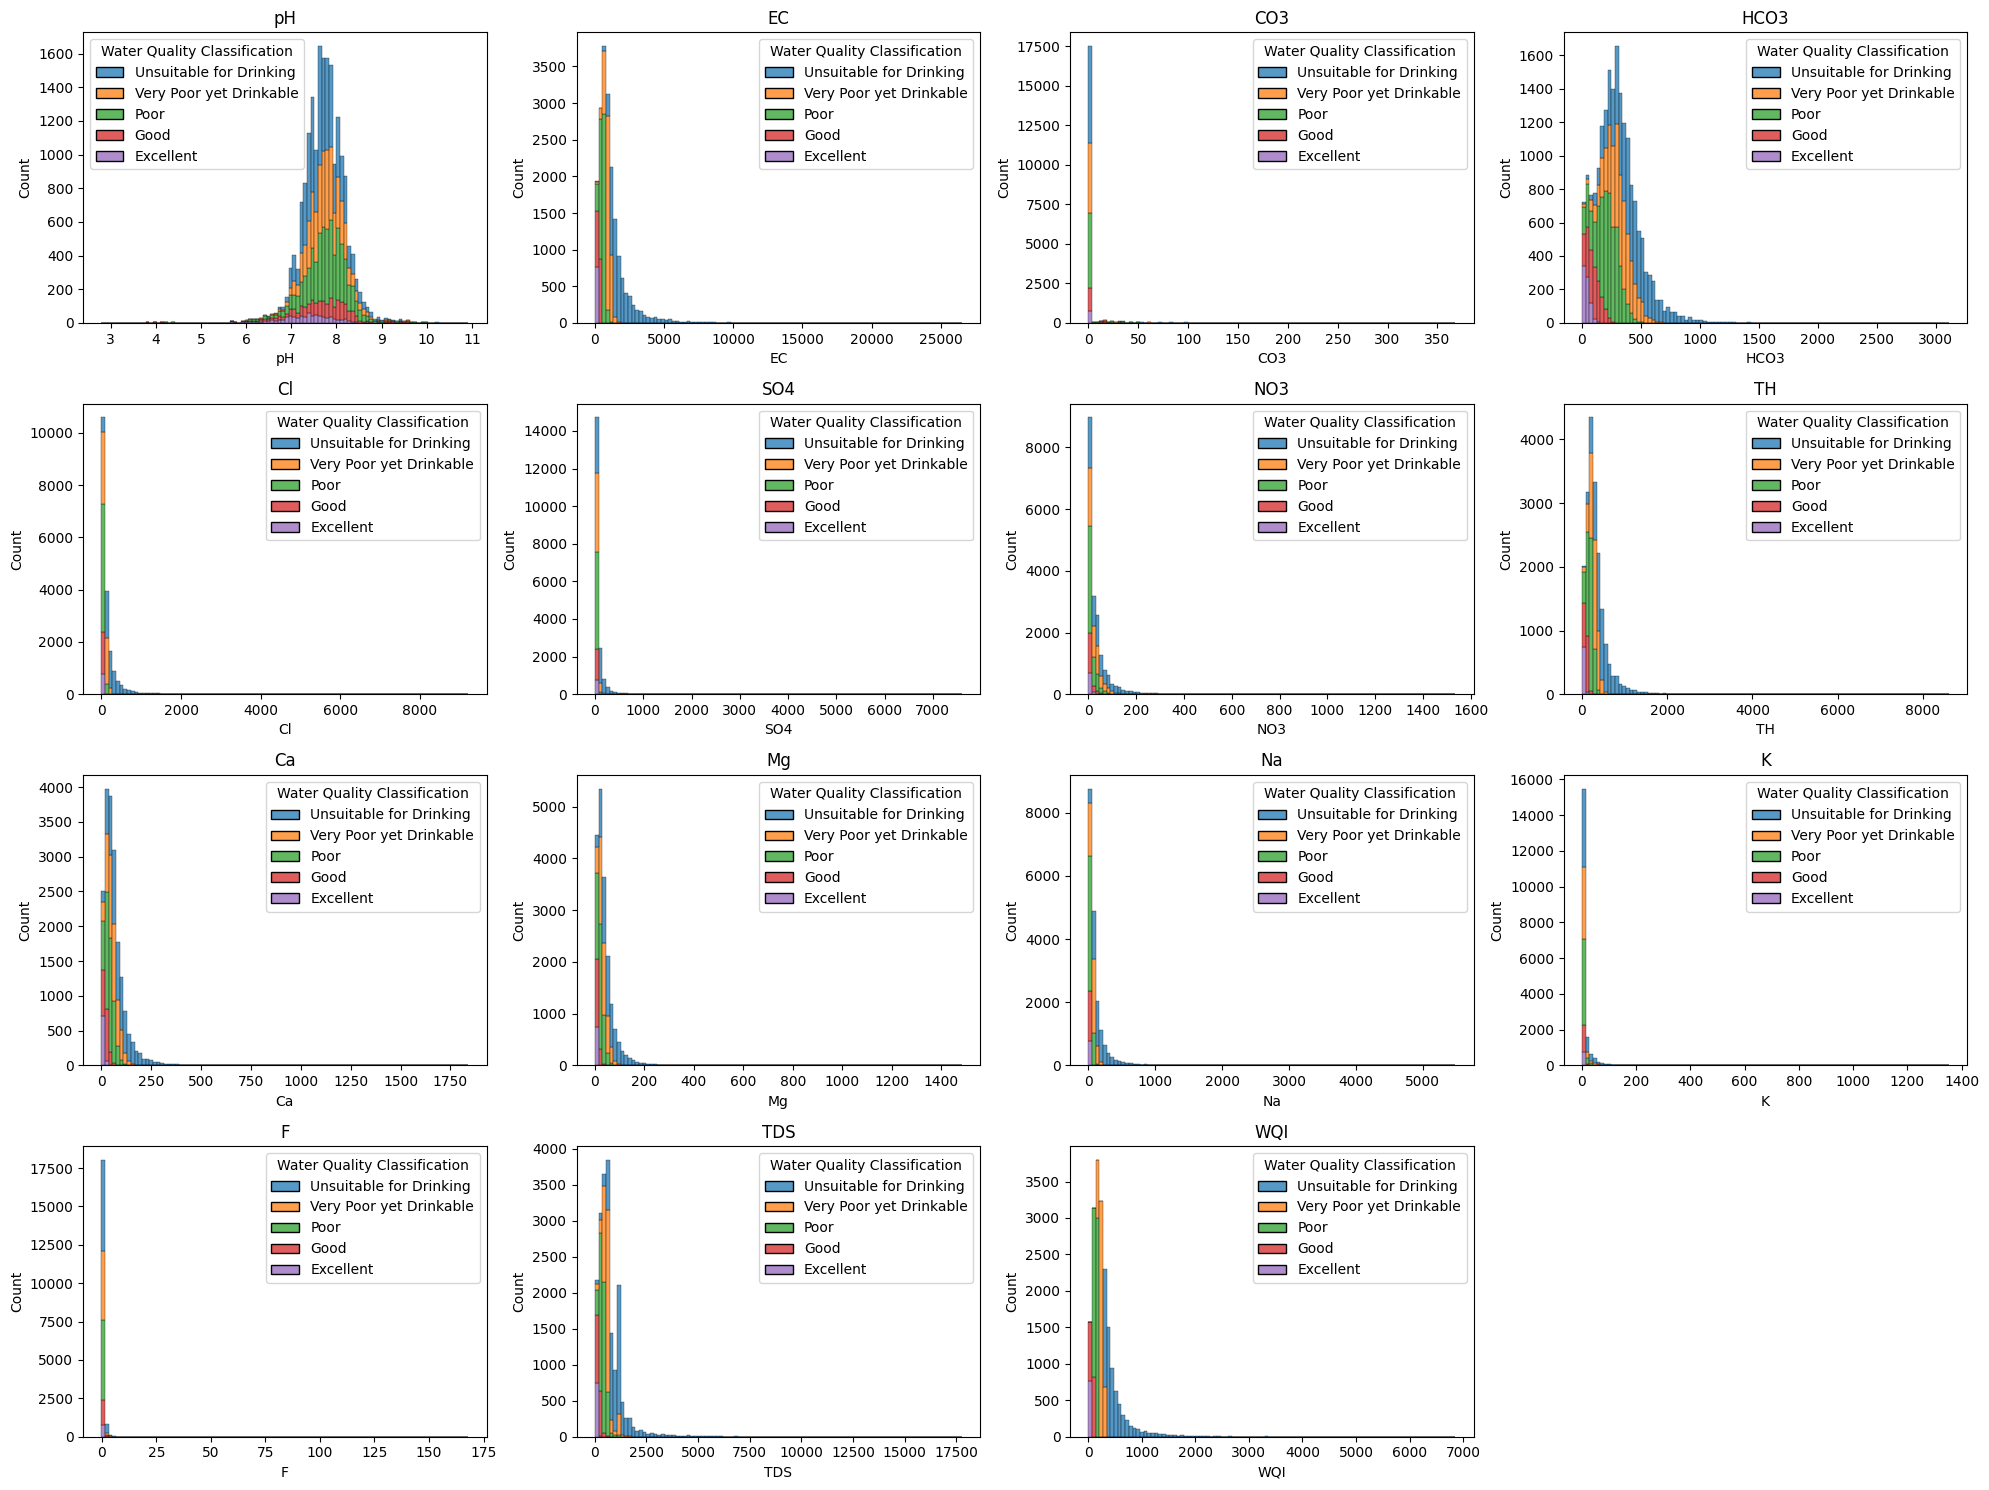

In [7]:
col_to_ignore = ["Latitude", "Longitude", "Year"]

col_to_plot = df.select_dtypes(include="number").drop(columns=col_to_ignore).columns


fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 15))
axes = axes.flatten()

# Plot each histogram in the subplot
for i, col in enumerate(col_to_plot):
    sns.histplot(data=df, x=col, bins=100, hue="Water Quality Classification", multiple="stack", ax=axes[i])
    axes[i].set_title(col)

# Hide any unused subplots
for j in range(len(col_to_plot), 16):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()

Feature exploration revealed that the majority of input variables, as well as the target variable (WQI), exhibit significant skewness. Notably, pH stands out as the only feature with a relatively symmetric distribution. To address this skewness and improve model performance, we will experiment with various transformation techniques—such as logarithmic, Power and Quantile transformations—to identify the most suitable approach for each feature.

#### Logarithmic Transformation

In [8]:
log_df = pd.DataFrame(np.log1p(df[col_to_plot]), columns=col_to_plot, index=df.index)
log_df["Water Quality Classification"] = df["Water Quality Classification"]

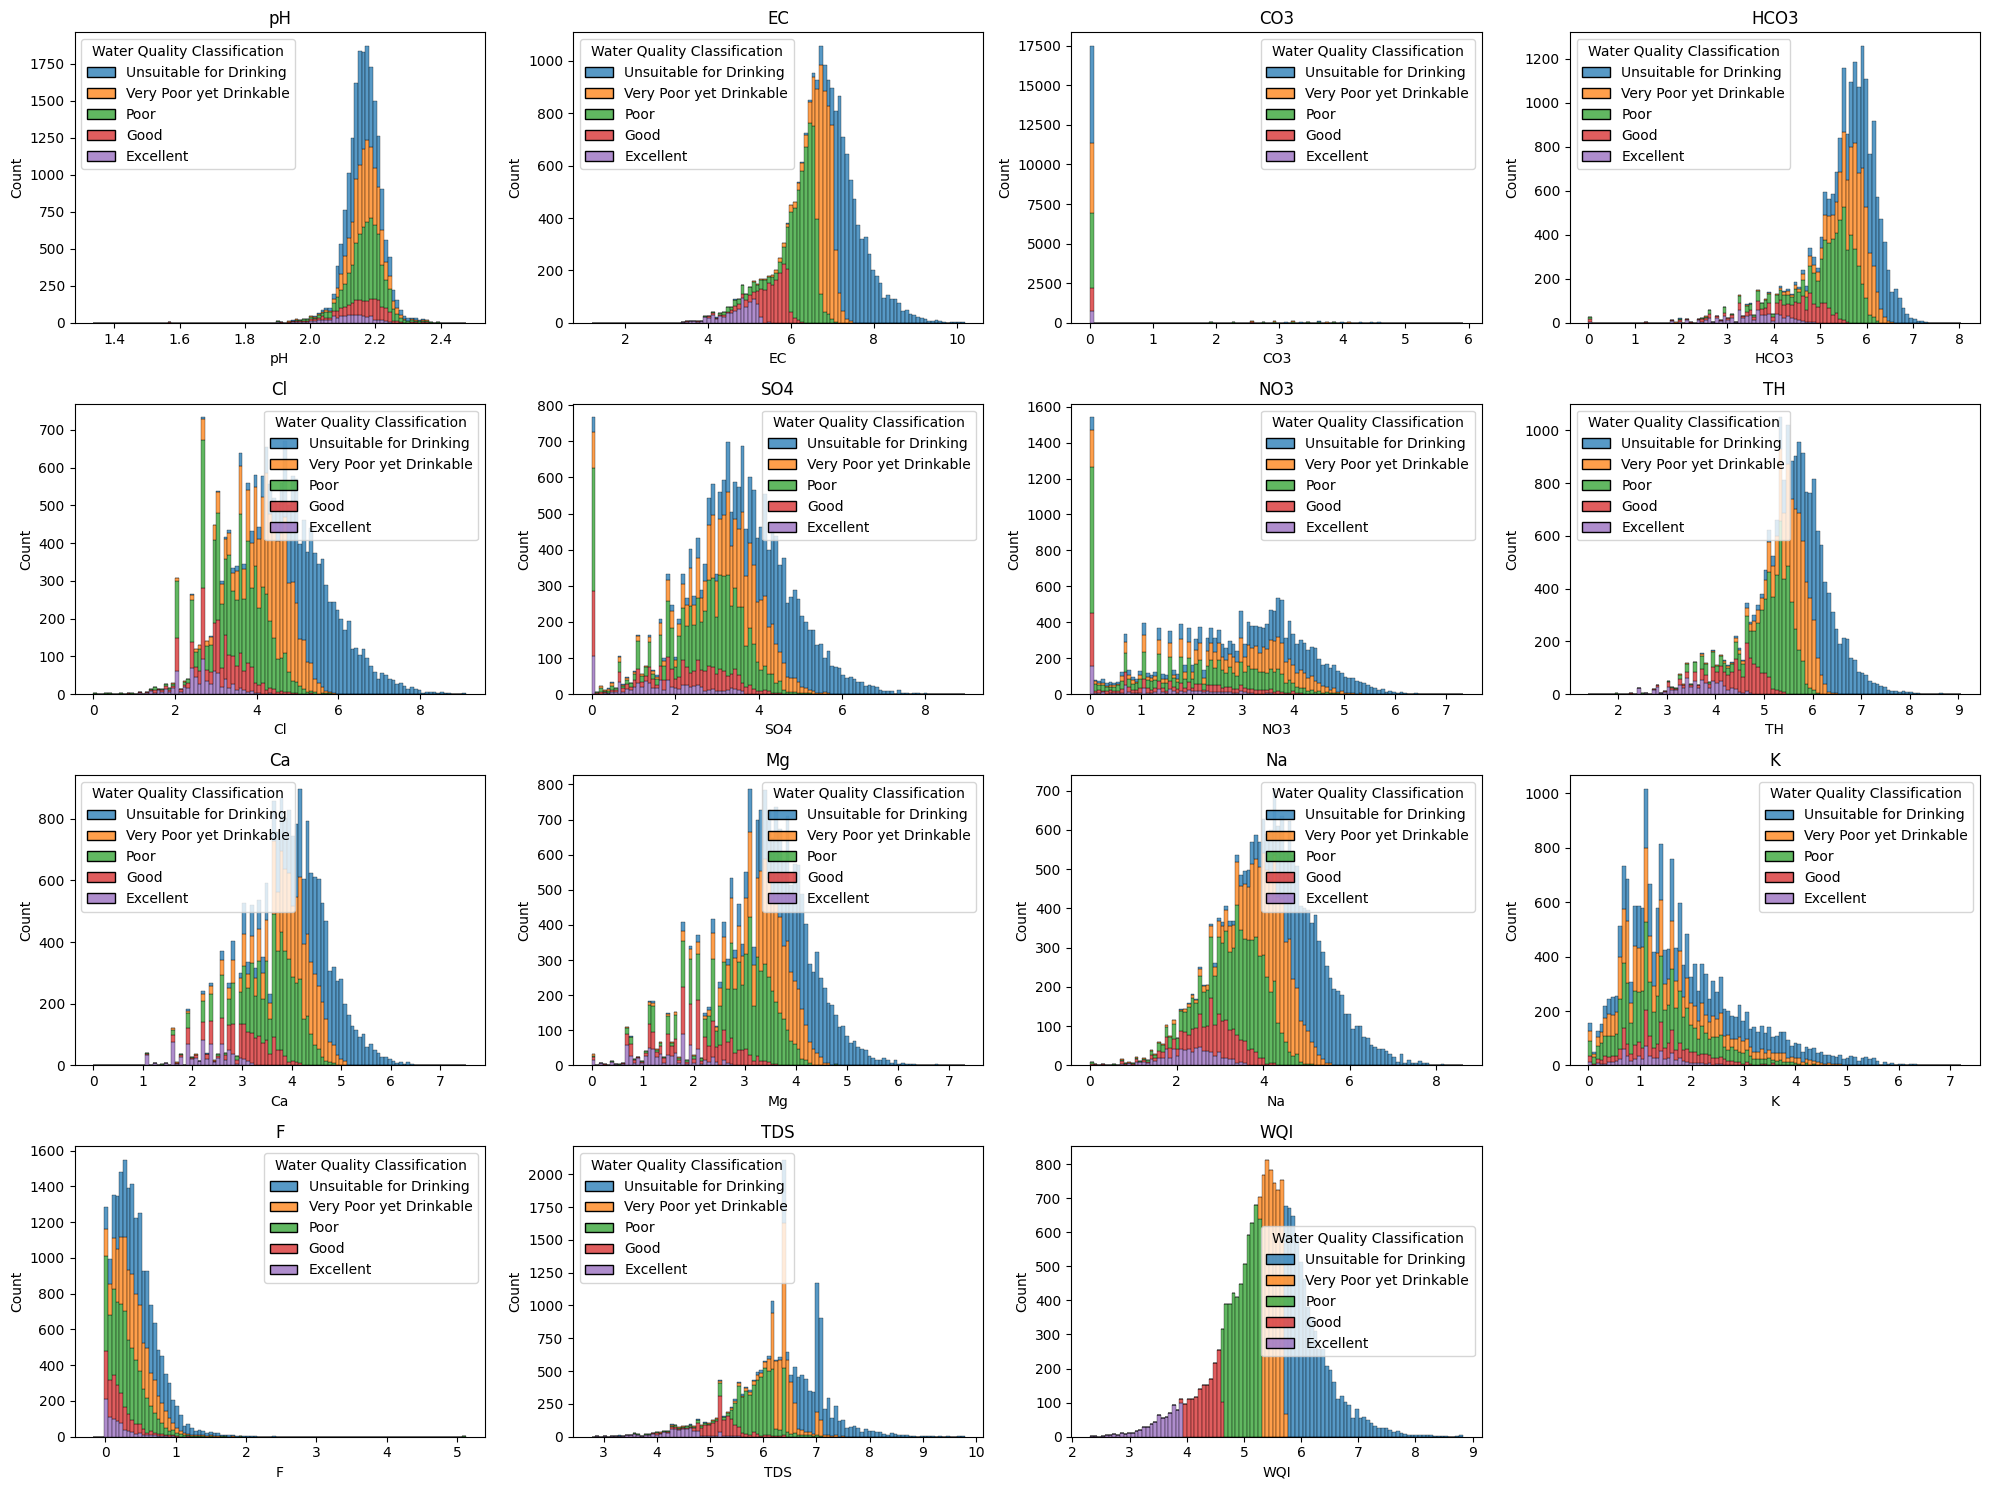

In [9]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 15))
axes = axes.flatten()

# Plot each histogram in the subplot
for i, col in enumerate(col_to_plot):
    sns.histplot(data=log_df, x=col, bins=100, hue="Water Quality Classification", multiple="stack", ax=axes[i])
    axes[i].set_title(col)

# Hide any unused subplots
for j in range(len(col_to_plot), 16):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()

#### Power Transformation

In [10]:
pt_scaler = PowerTransformer(method="yeo-johnson", standardize=True)

pt_df = pd.DataFrame(pt_scaler.fit_transform(df[col_to_plot]), columns=col_to_plot, index=df.index)
pt_df["Water Quality Classification"] = df["Water Quality Classification"]

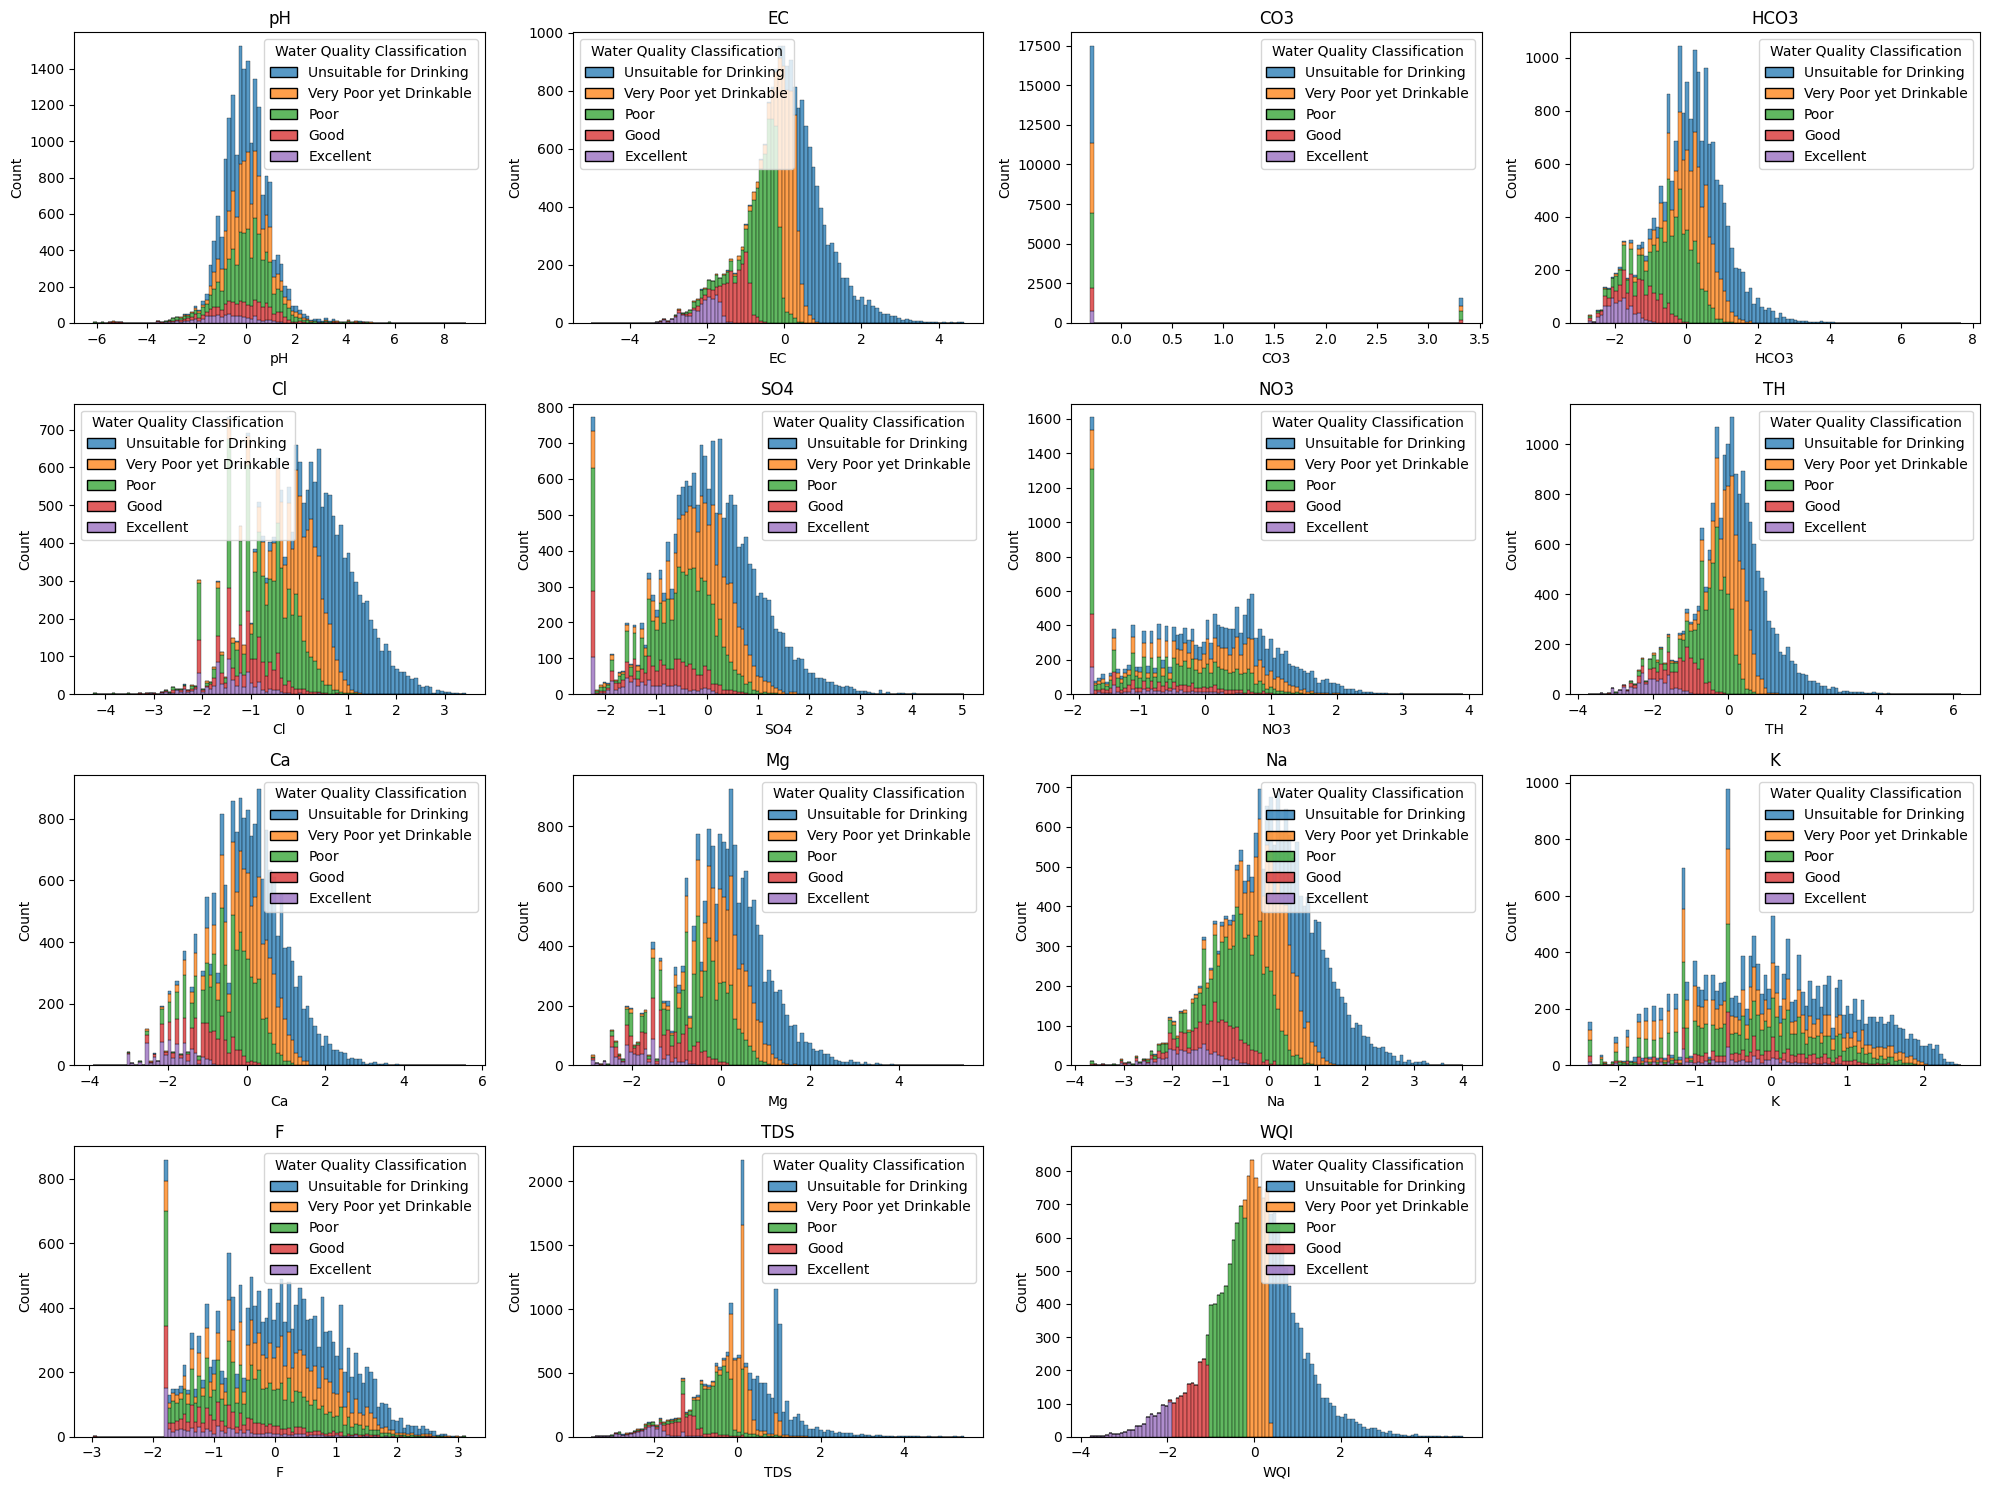

In [11]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 15))
axes = axes.flatten()

# Plot each histogram in the subplot
for i, col in enumerate(col_to_plot):
    sns.histplot(data=pt_df, x=col, bins=100, hue="Water Quality Classification", multiple="stack", ax=axes[i])
    axes[i].set_title(col)

# Hide any unused subplots
for j in range(len(col_to_plot), 16):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()

#### Quantile Transformation

In [12]:
qt_scaler = QuantileTransformer(output_distribution="normal", random_state=0)

qt_df = pd.DataFrame(qt_scaler.fit_transform(df[col_to_plot]), columns=col_to_plot, index=df.index)
qt_df["Water Quality Classification"] = df["Water Quality Classification"]

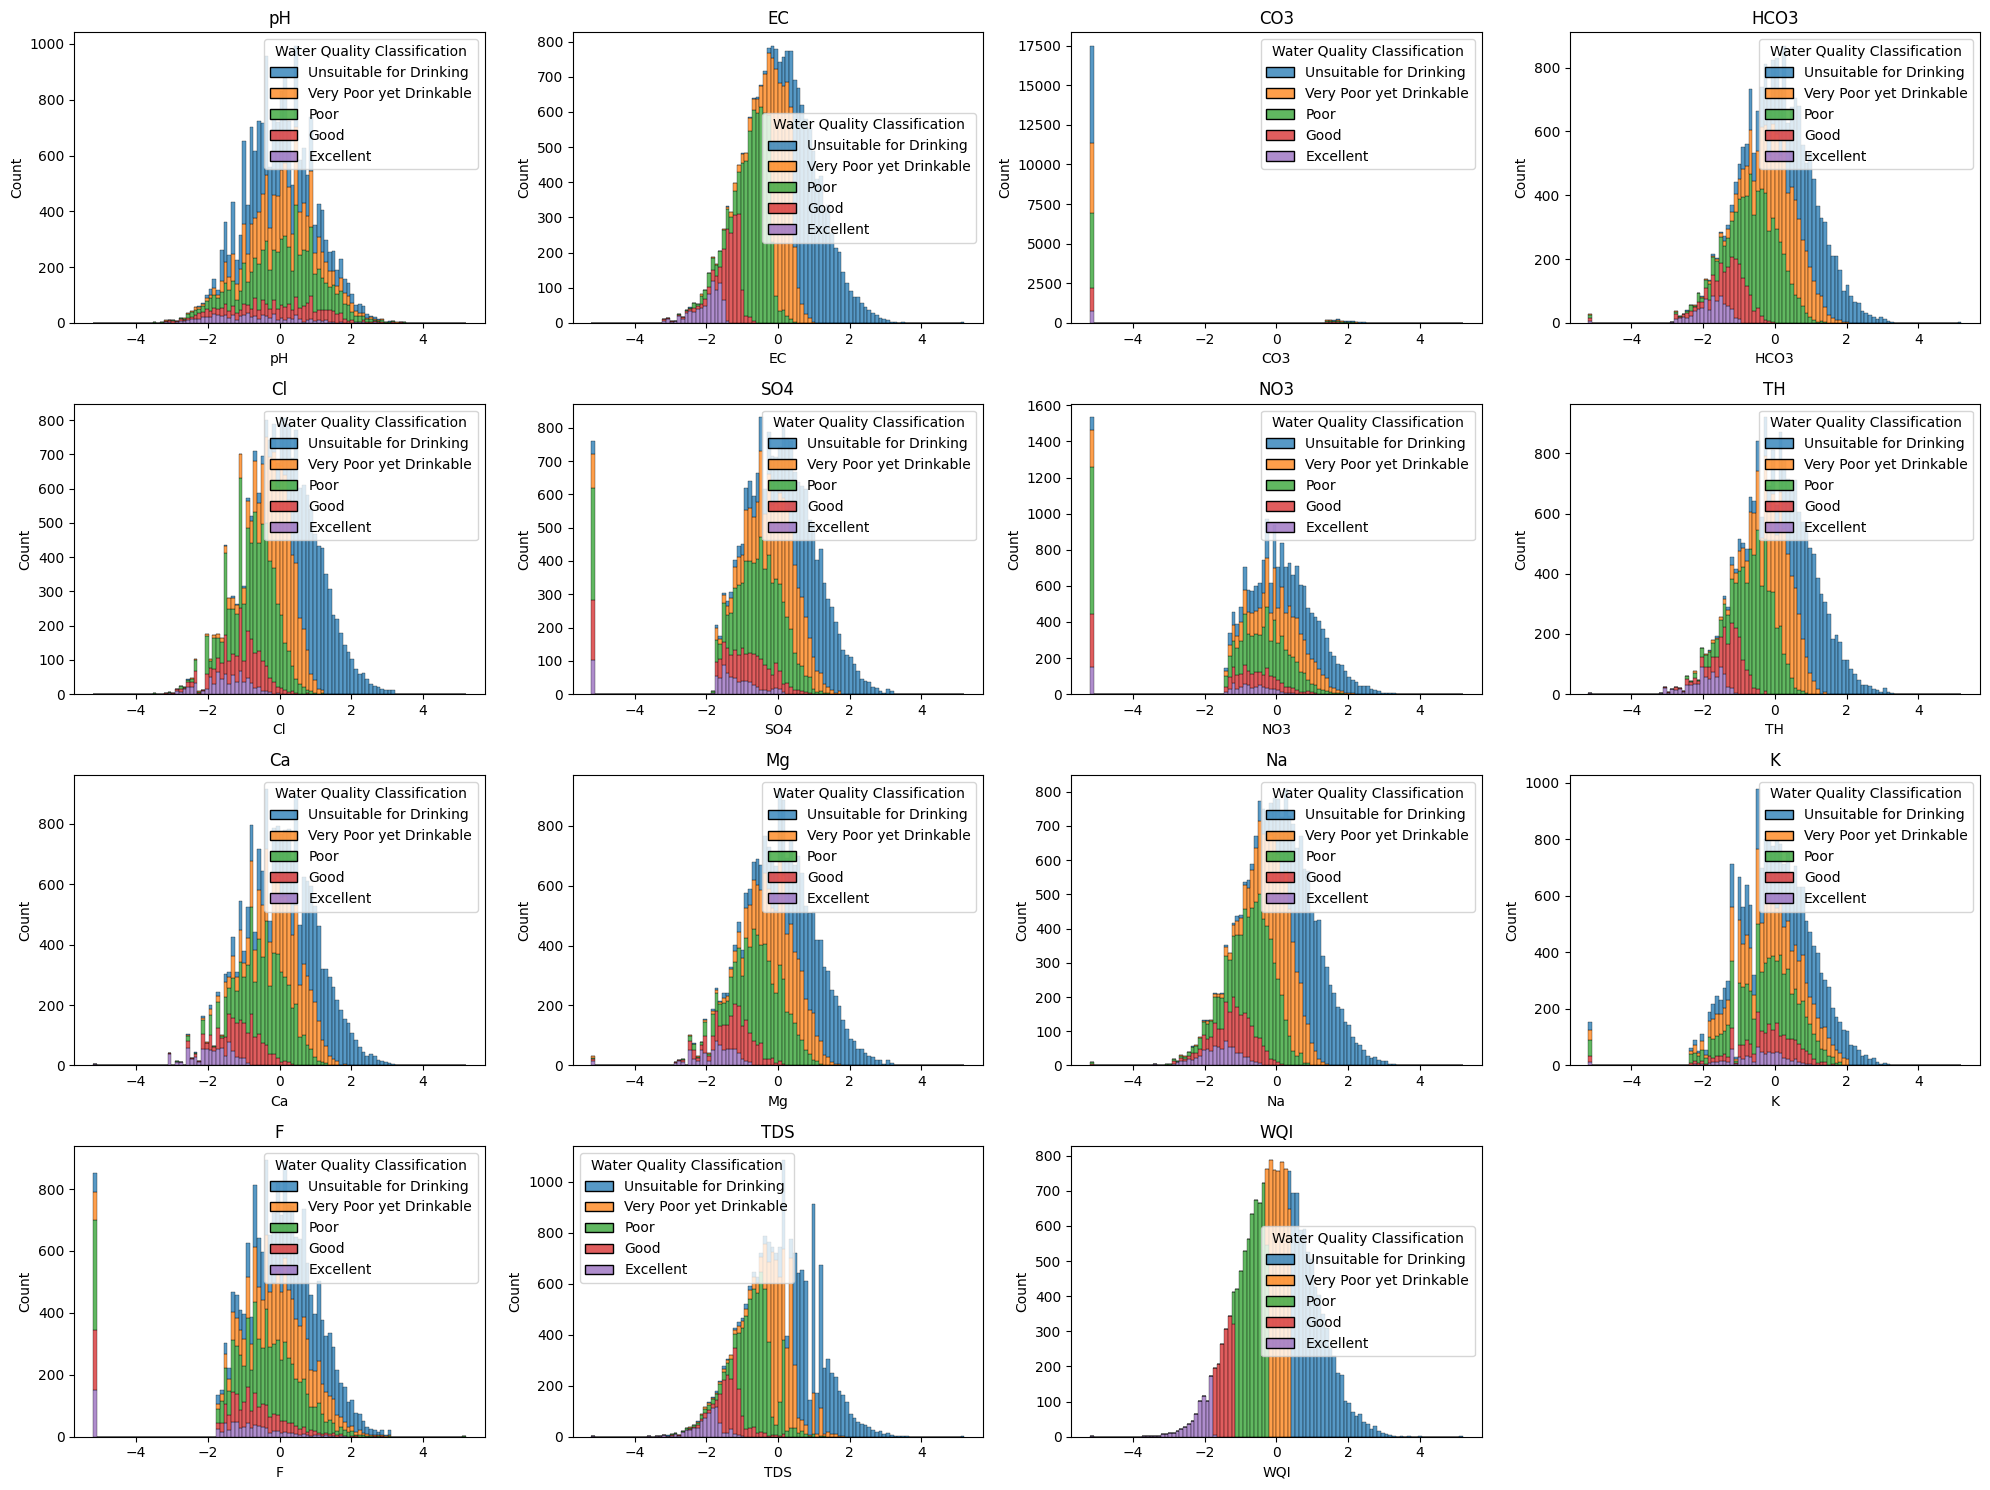

In [13]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 15))
axes = axes.flatten()

# Plot each histogram in the subplot
for i, col in enumerate(col_to_plot):
    sns.histplot(data=qt_df, x=col, bins=100, hue="Water Quality Classification", multiple="stack", ax=axes[i])
    axes[i].set_title(col)

# Hide any unused subplots
for j in range(len(col_to_plot), 16):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()

#### Conclusion

After evaluating several transformation techniques, we found that the quantile transformation consistently produced the most balanced distributions across both the features and the target variable (WQI). As a result, we plan to apply quantile transformation to all features and the target to mitigate skewness and enhance model performance.

### Feature Correlation

To further refine the input space and enhance model efficiency, we will conduct a feature correlation study. This will help identify highly correlated or redundant features, allowing us to reduce dimensionality by selecting only the most informative variables. This step is crucial for minimizing overfitting and improving generalization.

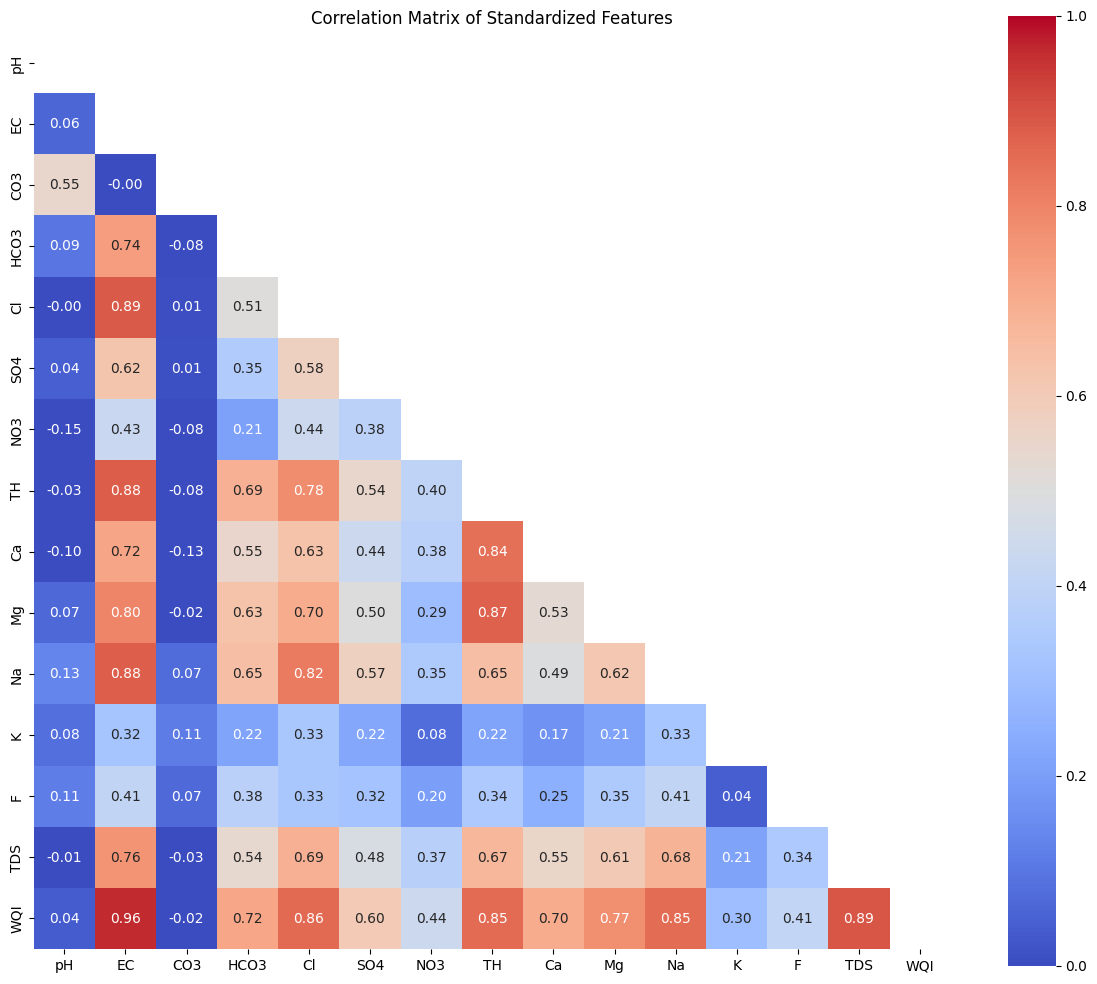

In [14]:
# Compute correlation matrix
corr_matrix = qt_df.drop(columns=["Water Quality Classification"]).corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot the correlation matrix heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, mask=mask, vmin=0, vmax=1)
plt.title("Correlation Matrix of Standardized Features")
plt.tight_layout()

We decided to drop EC, TH, Na, and CO3 from the feature set. EC was highly correlated with multiple features, making it redundant. TH and Na showed strong correlations with Cl, likely due to the presence of NaCl in water samples. CO3 was removed due to its very low correlation with WQI and a highly non-uniform data distribution. These removals help reduce multicollinearity and simplify the model while preserving predictive strength.

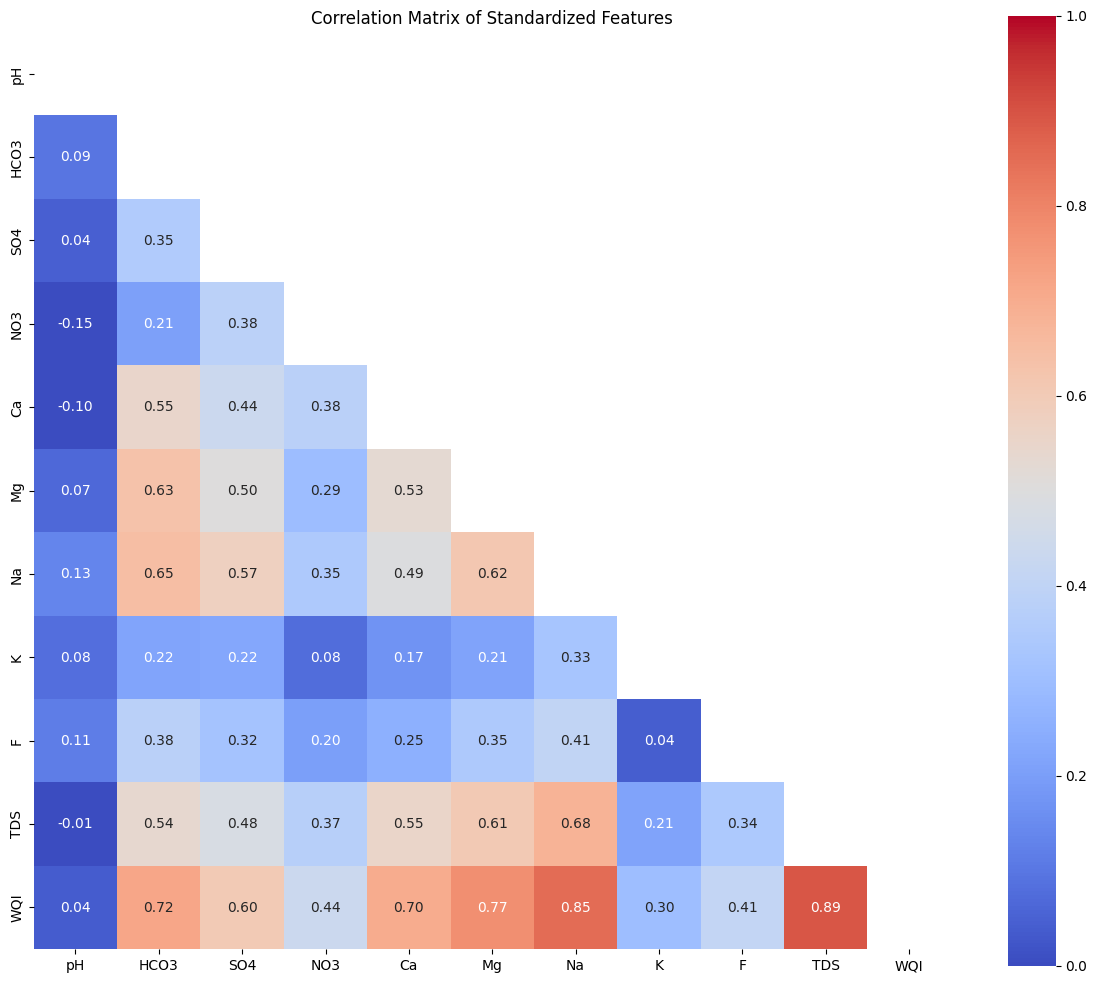

In [15]:
# Compute correlation matrix
corr_matrix = qt_df.drop(columns=["Water Quality Classification", "TH", "EC", "Cl", "CO3"]).corr()


# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))


# Plot the correlation matrix heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, mask=mask, vmin=0, vmax=1)
plt.title("Correlation Matrix of Standardized Features")
plt.tight_layout()

# Data Preprocessing

Based on the discussions above, we drop the geographical data and the year.

In [16]:
df.drop(
    columns=['Well_ID', 'State', 'District', 'Block', 'Village', 'Latitude', 'Longitude', 'Year', "TH", "EC", "Cl", "CO3"],
    inplace=True
)

df.head(2)

,pH,HCO3,SO4,NO3,Ca,Mg,Na,K,F,TDS,WQI,Water Quality Classification
0,8.20,1257.0,822.0,26.0,152.0,260.0,3535.0,45.0,1.0,11149,4361.44080,Unsuitable for Drinking
1,8.44,87.0,0.0,2.7,17.0,10.0,39.0,2.4,0.2,262,85.80466,Good


We check if the data has nulls and it has no nulls

In [17]:
columns_with_nans = df.columns[df.isna().any()].tolist()

# Print the names of columns with NaNs
print("Columns with NaNs:", columns_with_nans)
print("Number of columns with nans:", len(columns_with_nans))

Columns with NaNs: []
Number of columns with nans: 0


We split it into train and test, using the `WQI` as target (for training), but Keeping the Classification for accuracy calculations (Testing).

In [18]:
X = df.drop(columns=['WQI', 'Water Quality Classification'], axis=1)
y = df[['WQI', 'Water Quality Classification']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=True)

y_wqi_train = y_train['WQI']
y_wqc_train = y_train['Water Quality Classification']
y_wqi_test = y_test['WQI']
y_wqc_test = y_test['Water Quality Classification']

We check if the train-test target split is stratified.

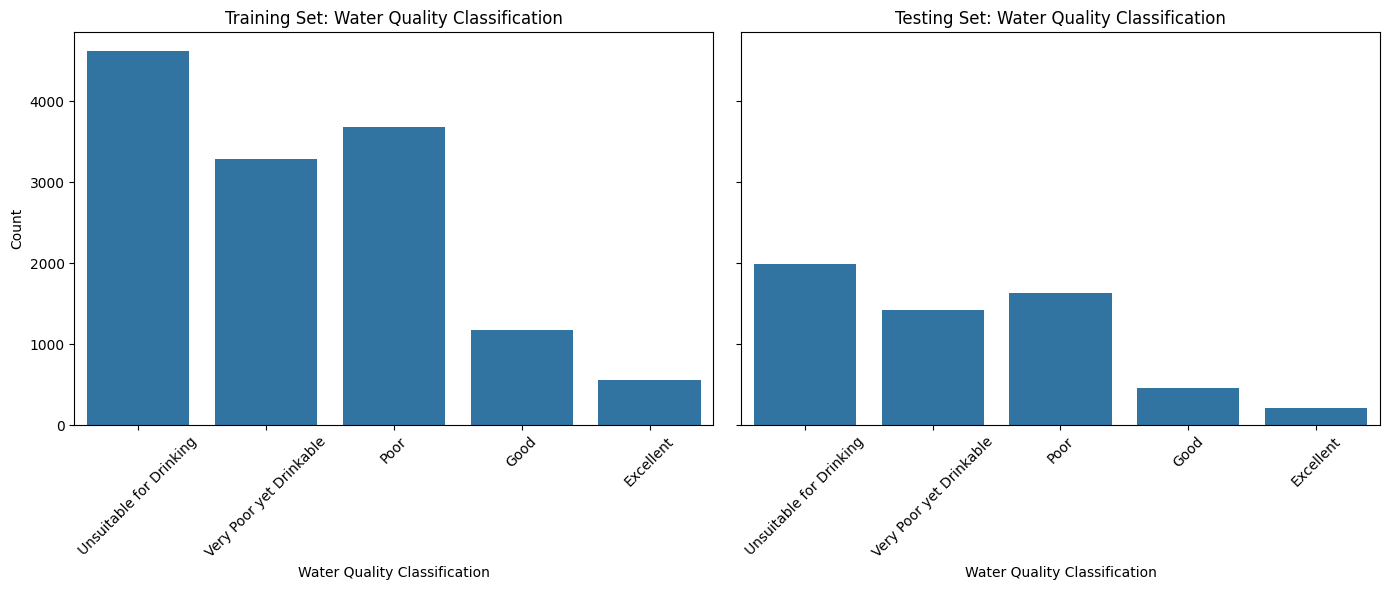

In [19]:
# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Count plot for training set
sns.countplot(x=y_wqc_train, ax=axes[0])
axes[0].set_title('Training Set: Water Quality Classification')
axes[0].set_xlabel('Water Quality Classification')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Count plot for testing set
sns.countplot(x=y_wqc_test, ax=axes[1])
axes[1].set_title('Testing Set: Water Quality Classification')
axes[1].set_xlabel('Water Quality Classification')
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


Since we have only numerical variable, we will apply only the numerical transformer.

In [20]:
X_scaler = QuantileTransformer(output_distribution="normal", random_state=0)

X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

X_train[:2]

array([[ 1.19462844, -1.4979966 ,  0.25231085, -0.97870102, -0.71359852,
        -0.98561042, -2.44486933, -1.83797516, -0.35081689, -1.47526936],
       [ 0.88830934,  0.89953386,  0.54524419, -0.8462785 ,  0.33485067,
         0.24713363,  0.28467955,  1.08583486,  1.06409142, -0.48930663]])

We also transform the target WQI.

In [21]:
y_scaler = QuantileTransformer(output_distribution="normal", random_state=0)

y_wqi_train_qt = y_scaler.fit_transform(y_wqi_train.values.reshape(-1, 1)).flatten()
y_wqi_test_qt = y_scaler.transform(y_wqi_test.values.reshape(-1, 1))

In [22]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_wqi_train_qt, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_wqi_test_qt, dtype=torch.float32)

We convert the NumPy arrays into Torch Tensors

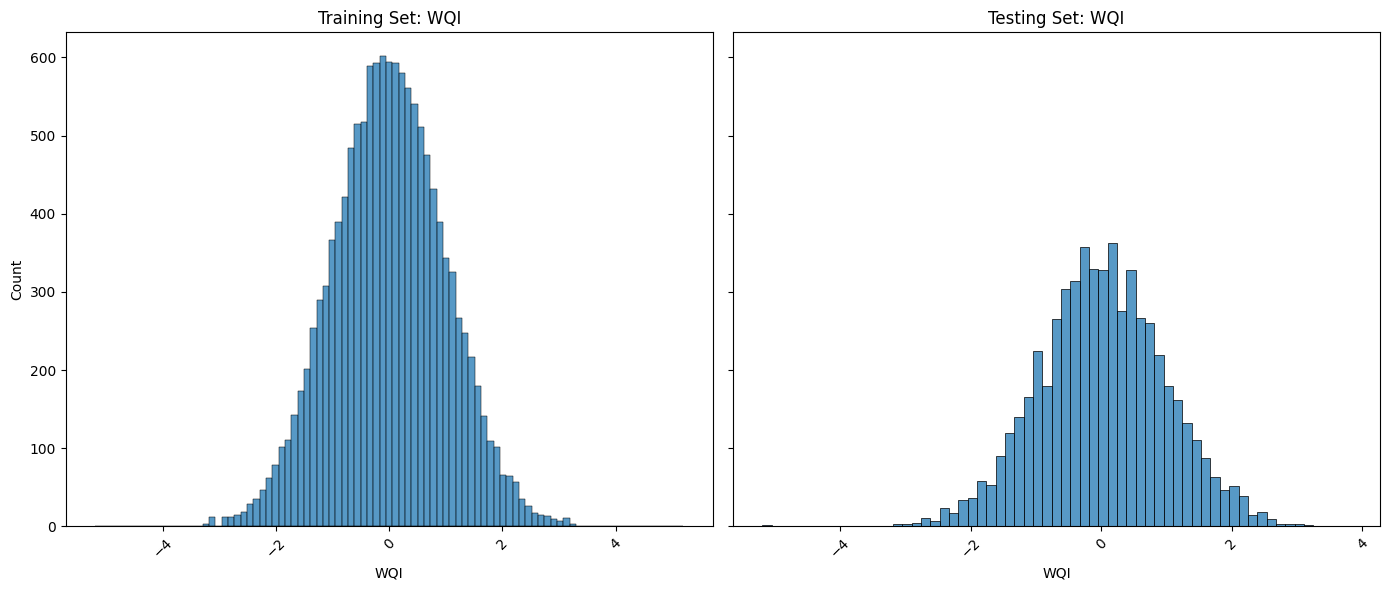

In [23]:
# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Count plot for training set
sns.histplot(x=y_train_tensor, ax=axes[0])
axes[0].set_title('Training Set: WQI')
axes[0].set_xlabel('WQI')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Count plot for testing set
sns.histplot(x=y_test_tensor.flatten(), ax=axes[1])
axes[1].set_title('Testing Set: WQI')
axes[1].set_xlabel('WQI')
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()

After quantile-transformation, the target has a normal distribution.

## NN Model

We will use MSE loss.

In [24]:
loss_fn = nn.MSELoss()

We prepare a simple shallow ANN.

In [25]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define the three linear layers
        self.fc1 = nn.Linear(X_test_tensor.shape[1], 8)
        self.fc2 = nn.Linear(8, 1)
        
    def forward(self, x):
        # Pass x through linear layers adding activations
        x = F.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

### Attempt 1 - Using SGD

In [26]:
model = Net()

optimizer = optim.SGD(model.parameters(), lr = 1e-3, momentum=0.9)

train_loss_list=[]
test_loss_list = []

num_epochs = 100

train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size= 64, shuffle=True) 

#### Training

In [27]:
# Execute the training loop
for epoch in range(num_epochs): # increasing the epochs for effective training
    for X_batch, y_batch in train_loader:
        # Forward pass
        pred = model(X_batch).squeeze()
        loss = loss_fn(pred, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = loss_fn(model(X_train_tensor).squeeze(), y_train_tensor).item()
    test_loss = loss_fn(model(X_test_tensor), y_test_tensor).item()
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    if (epoch+1) % 10 == 0 or epoch == 0: # printing after every 10 epochs
        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    

Epoch 1: Train Loss: 0.2589, Test Loss: 0.2489
Epoch 10: Train Loss: 0.0426, Test Loss: 0.0409
Epoch 20: Train Loss: 0.0380, Test Loss: 0.0364
Epoch 30: Train Loss: 0.0360, Test Loss: 0.0345
Epoch 40: Train Loss: 0.0346, Test Loss: 0.0333
Epoch 50: Train Loss: 0.0335, Test Loss: 0.0323
Epoch 60: Train Loss: 0.0325, Test Loss: 0.0314
Epoch 70: Train Loss: 0.0316, Test Loss: 0.0306
Epoch 80: Train Loss: 0.0307, Test Loss: 0.0298
Epoch 90: Train Loss: 0.0299, Test Loss: 0.0289
Epoch 100: Train Loss: 0.0291, Test Loss: 0.0282


#### Evaluation

In [28]:
# Predict WQI values using X_test
y_wqi_pred = model(X_test_tensor).detach().numpy()

# Calculate R² score
r2 = r2_score(y_test_tensor, y_wqi_pred)

# Print the R² score
print(f"R² score for WQI prediction: {r2:.4f}")

R² score for WQI prediction: 0.9704


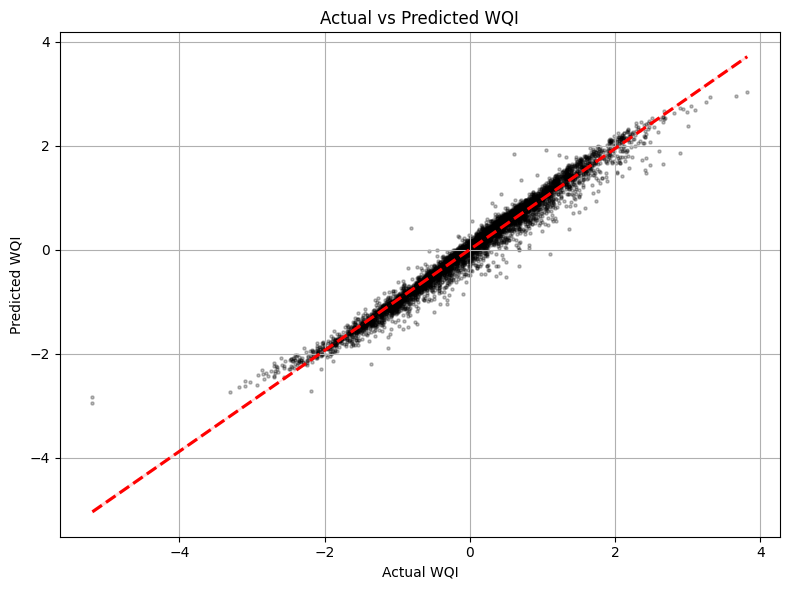

In [29]:
# Create a DataFrame for plotting
df_plot = pd.DataFrame({
    'Actual WQI': y_test_tensor.flatten(),
    'Predicted WQI': y_wqi_pred.flatten()
})

# Create scatter plot using seaborn
plt.figure(figsize=(8, 6))
sns.regplot(
    x='Actual WQI', y='Predicted WQI', data=df_plot,
    scatter_kws={'color': 'black', 's': 5, 'alpha': 0.25},
    line_kws={'color': 'red', 'linestyle': '--'}
)
plt.title('Actual vs Predicted WQI')
plt.xlabel('Actual WQI')
plt.ylabel('Predicted WQI')
plt.grid(True)
plt.tight_layout()

In [30]:
# First inverse the transformation
y_wqi_pred_real = y_scaler.inverse_transform(y_wqi_pred)

# Put in a series
y_wqi_pred_real = pd.Series(y_wqi_pred_real.flatten())

# Apply classification function to predicted WQI values
y_wqc_pred = y_wqi_pred_real.apply(classify_water_quality)

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_wqc_test, y_wqc_pred)
f1 = f1_score(y_wqc_test, y_wqc_pred, average='weighted')

# Display results
accuracy, f1

(0.8913995445787354, 0.8912094962636821)

### Attempt 2 - Using Adam

#### Training

In [31]:
model = Net()

# Optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
train_loss_list = []
test_loss_list = []

for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        pred = model(X_batch).squeeze()
        loss = loss_fn(pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        train_loss = loss_fn(model(X_train_tensor).squeeze(), y_train_tensor).item()
        test_loss = loss_fn(model(X_test_tensor).squeeze(), y_test_tensor.squeeze()).item()
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)

    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


Epoch 1: Train Loss: 0.4297, Test Loss: 0.4133
Epoch 10: Train Loss: 0.0419, Test Loss: 0.0406
Epoch 20: Train Loss: 0.0248, Test Loss: 0.0246
Epoch 30: Train Loss: 0.0175, Test Loss: 0.0173
Epoch 40: Train Loss: 0.0153, Test Loss: 0.0150
Epoch 50: Train Loss: 0.0144, Test Loss: 0.0141
Epoch 60: Train Loss: 0.0139, Test Loss: 0.0135
Epoch 70: Train Loss: 0.0132, Test Loss: 0.0129
Epoch 80: Train Loss: 0.0125, Test Loss: 0.0122
Epoch 90: Train Loss: 0.0123, Test Loss: 0.0120
Epoch 100: Train Loss: 0.0121, Test Loss: 0.0118


#### Evaluation

In [32]:
# Predict WQI values using X_test
y_wqi_pred = model(X_test_tensor).detach().numpy()

# Calculate R² score
r2 = r2_score(y_test_tensor, y_wqi_pred)

# Print the R² score
print(f"R² score for WQI prediction: {r2:.4f}")

R² score for WQI prediction: 0.9876


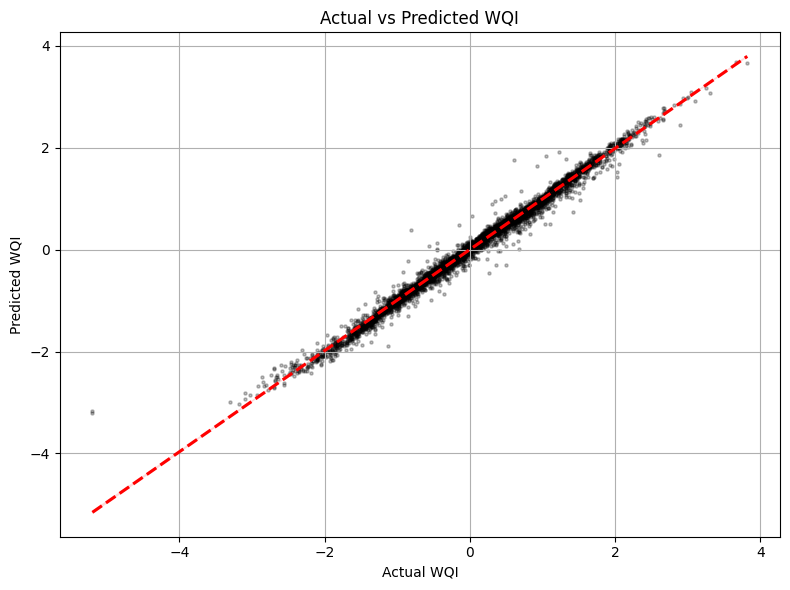

In [33]:
# Create a DataFrame for plotting
df_plot = pd.DataFrame({
    'Actual WQI': y_test_tensor.flatten(),
    'Predicted WQI': y_wqi_pred.flatten()
})

# Create scatter plot using seaborn
plt.figure(figsize=(8, 6))
sns.regplot(
    x='Actual WQI', y='Predicted WQI', data=df_plot,
    scatter_kws={'color': 'black', 's': 5, 'alpha': 0.25},
    line_kws={'color': 'red', 'linestyle': '--'}
)
plt.title('Actual vs Predicted WQI')
plt.xlabel('Actual WQI')
plt.ylabel('Predicted WQI')
plt.grid(True)
plt.tight_layout()

In [34]:
# First inverse the transformation
y_wqi_pred_real = y_scaler.inverse_transform(y_wqi_pred)

# Put in a series
y_wqi_pred_real = pd.Series(y_wqi_pred_real.flatten())

# Apply classification function to predicted WQI values
y_wqc_pred = y_wqi_pred_real.apply(classify_water_quality)

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_wqc_test, y_wqc_pred)
f1 = f1_score(y_wqc_test, y_wqc_pred, average='weighted')

# Display results
accuracy, f1

(0.9332632685233841, 0.933235162070027)

## References

- [Application of artificial neural network (ANN) for water quality index (WQI) prediction for the river Warta, Poland](https://iopscience.iop.org/article/10.1088/1742-6596/2130/1/012028)
- [Artificial Neural Network (ANN)-Based Water Quality Index (WQI) for Assessing Spatiotemporal Trends in Surface Water Quality—A Case Study of South African River Basins](https://www.mdpi.com/2073-4441/16/11/1485)
- [Water Quality Prediction Based on Machine Learning and Comprehensive Weighting Methods](https://www.mdpi.com/1099-4300/25/8/1186)